In [121]:
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

db = mysql.connector.connect (
    host="localhost",
    user="root",
    password="1234",
    database="ecommerce"
)
cursor = db.cursor()

## List all unique cities where customers are located.

In [78]:
query = """SELECT DISTINCT customer_city FROM ecommerce.customers"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['customer_city'])
df.head(10)


,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


## Count the number of orders placed in 2017.

In [122]:
query = """SELECT count(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017"""
cursor.execute(query)
data = cursor.fetchall()

"Total Orders placed in 2017 are", data[0][0]

('Total Orders placed in 2017 are', 45101)

## Find the total sales per category.

In [82]:
query = """SELECT products.product_category AS Products, SUM(payments.payment_value) AS Sales
FROM ecommerce.products join ecommerce.order_items
ON products.product_id = order_items.product_id
JOIN ecommerce.payments
ON payments.order_id = order_items.order_id
GROUP BY products.product_category"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Products', 'Sales'])
df.head(10)

,Products,Sales
0,perfumery,5.067387e+05
1,Furniture Decoration,1.430176e+06
2,telephony,4.868821e+05
3,bed table bath,1.712554e+06
4,automotive,8.522943e+05
5,computer accessories,1.585330e+06
6,housewares,1.094758e+06
7,babies,5.398457e+05
8,toys,6.190377e+05
9,Furniture office,6.468265e+05


## Calculate the percentage of orders that were paid in installments.

In [83]:
query ="""SELECT COUNT(CASE WHEN payment_installments >= 1 THEN 1 END) * 100/ COUNT(order_id) AS installments_percentage
FROM ecommerce.payments"""
cursor.execute(query)
data = cursor.fetchall()

"The Percentage of Orders that were paid in installments is", data[0][0]

('The Percentage of Orders that were paid in installments is',
 Decimal('99.9981'))

## Count the number of customers from each state.

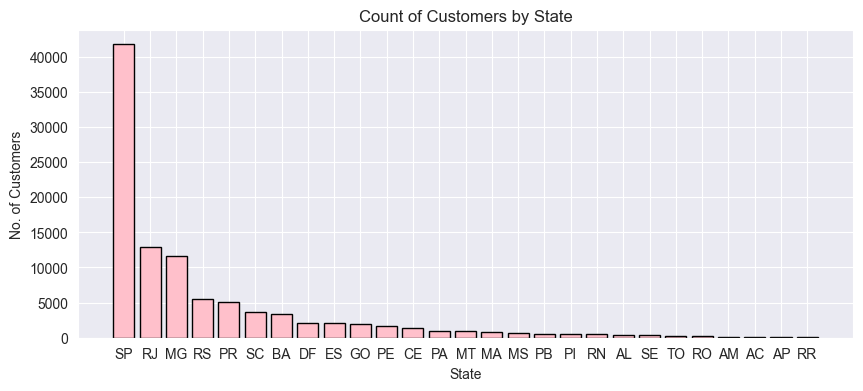

In [128]:
query = """SELECT customer_state, COUNT(*) AS customer_count FROM ecommerce.customers
GROUP BY customer_state
ORDER BY customer_count desc"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['customer_state', 'customer_count'])

plt.figure(figsize = (10,4))
plt.bar(df['customer_state'], df['customer_count'], color = 'pink', edgecolor = 'black')
plt.xlabel('State')
plt.ylabel('No. of Customers')
plt.title('Count of Customers by State')
plt.show()


## Calculate the number of orders per month in 2018.

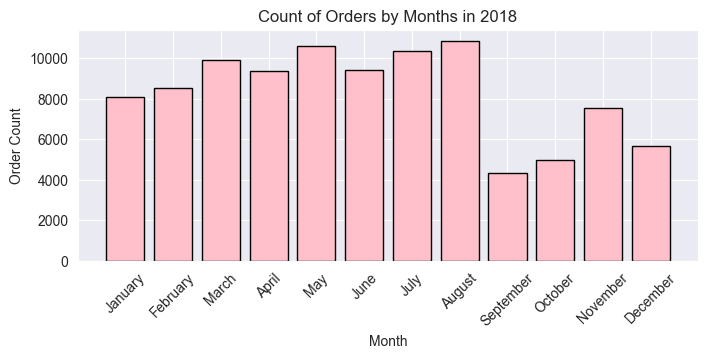

In [86]:
query = """SELECT MONTHNAME(order_purchase_timestamp) AS Month,
COUNT(*) AS order_count
FROM ecommerce.orders
GROUP BY MONTH(order_purchase_timestamp), Month
ORDER BY MONTH(order_purchase_timestamp)"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Month', 'order_count'])

plt.figure(figsize = (8,3))
plt.bar(df["Month"], df["order_count"], color = "pink", edgecolor = "black")
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Order Count')
plt.title("Count of Orders by Months in 2018")
plt.show()


## Find the average number of products per order, grouped by customer city.

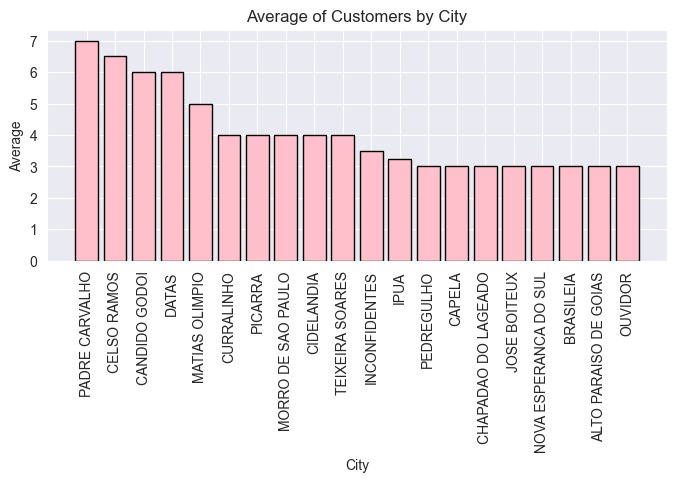

In [90]:
query = """WITH products_per_order AS (
SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_item_id) AS abc
FROM ecommerce.orders JOIN ecommerce.order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id
)
SELECT UPPER(customers.customer_city), ROUND(AVG(abc), 2) AS average
FROM ecommerce.customers JOIN products_per_order
ON customers.customer_id = products_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY average DESC LIMIT 20"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['City', 'City Average'])

plt.figure(figsize = (8,3))
plt.bar(df['City'], df['City Average'], color = 'pink', edgecolor = 'black')
plt.xlabel('City')
plt.ylabel('Average')
plt.title('Average of Customers by City')
plt.xticks(rotation = 90)
plt.show()

## Calculate the percentage of total revenue contributed by each product category.

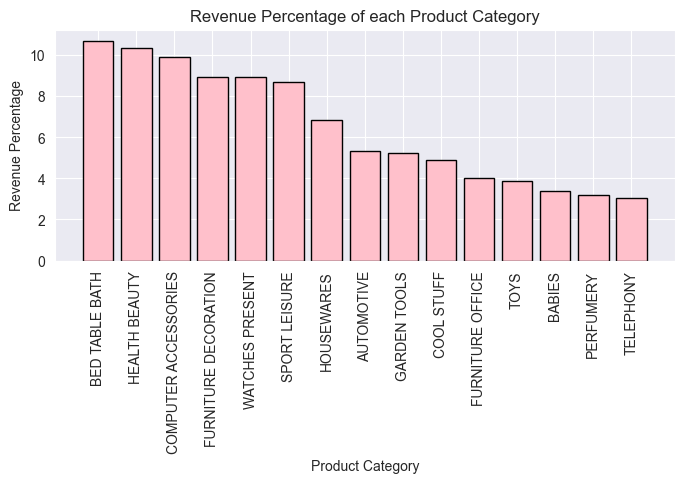

In [92]:
query = """SELECT UPPER(products.product_category) AS Product,
ROUND(SUM(payments.payment_value)* 100/ (SELECT SUM(payment_value) FROM ecommerce.payments), 2) AS Revenue_Percentage
FROM ecommerce.products JOIN ecommerce.order_items
ON products.product_id = order_items.product_id
JOIN ecommerce.payments
ON payments.order_id = order_items.order_id
GROUP BY products.product_category
ORDER BY revenue_percentage DESC LIMIT 15"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Product', 'Revenue_Percentage'])

plt.figure(figsize = (8,3))
plt.bar(df['Product'], df['Revenue_Percentage'], color = 'pink', edgecolor = 'black')
plt.xlabel('Product Category')
plt.ylabel('Revenue Percentage')
plt.title('Revenue Percentage of each Product Category')
plt.xticks(rotation = 90)
plt.show()

## Identify the correlation between product price and the number of times a product has been purchased.

In [93]:
query ="""SELECT products.product_category AS Product,
COUNT(order_items.order_item_id) AS Order_Count, ROUND(SUM(payments.payment_value), 2) AS Price
FROM ecommerce.products JOIN ecommerce.order_items
ON products.product_id = order_items.product_id
JOIN ecommerce.payments
ON payments.order_id = order_items.order_id
GROUP BY products.product_category"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Product', 'Order_Count', 'Price'])

arr1 = df["Order_Count"]
arr2 = df["Price"]

a = np.corrcoef([arr1,arr2])
print("The Correlation between Product Price and the Number of Times a Product has been Purchased is", a[0][-1])

The Correlation between Product Price and the Number of Times a Product has been Purchased is 0.9727126898947287


## Calculate the total revenue generated by each seller, and rank them by revenue.

In [95]:
query ="""SELECT *, DENSE_RANK() over (ORDER BY revenue DESC) AS rnk
FROM (
SELECT order_items.seller_id, ROUND(SUM(payments.payment_value), 2) AS revenue
FROM ecommerce.payments JOIN ecommerce.order_items
ON payments.order_id = order_items.order_id
GROUP BY order_items.seller_id
) t"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Seller ID', 'Revenue', 'Rank'])
df.head(10)

,Seller ID,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.21,10


## Calculate the moving average of order values for each customer over their order history.

In [123]:
query = """SELECT customer_id, order_purchase_timestamp, payment,
ROUND(AVG(payment) over (PARTITION BY customer_id ORDER BY order_purchase_timestamp rows between 2 preceding and current row), 2)
 AS moving_average
FROM (
SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value AS payment
FROM ecommerce.payments JOIN ecommerce.orders
ON payments.order_id = orders.order_id
) AS r"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Customer ID', 'Order Purchase Timestamp','Payment', 'Moving Average'])
df.head(10)

,Customer ID,Order Purchase Timestamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.80
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.40
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.59
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.23
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.71


## Calculate the cumulative sales per month for each year.

In [124]:
query = """SELECT YEAR(orders.order_purchase_timestamp) AS year,
MONTH(orders.order_purchase_timestamp) AS month, ROUND(SUM(payments.payment_value), 2) AS sales
FROM ecommerce.orders JOIN ecommerce.payments
ON orders.order_id = payments.order_id
GROUP BY year, month
ORDER BY year, month"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Year', 'Month', 'Sales'])
df

,Year,Month,Sales
0,2016,9,252.24
1,2016,10,59090.48
2,2016,12,19.62
3,2017,1,138488.04
4,2017,2,291908.01
5,2017,3,449863.60
6,2017,4,417788.03
7,2017,5,592918.82
8,2017,6,511276.38
9,2017,7,592382.92


## Calculate the year-over-year growth rate of total sales.

In [45]:
query = """WITH a AS (
SELECT YEAR(orders.order_purchase_timestamp) AS year, ROUND(SUM(payments.payment_value), 2) AS sales
FROM ecommerce.orders JOIN ecommerce.payments
ON orders.order_id = payments.order_id
GROUP BY year
ORDER BY year
),
b AS (
SELECT year, sales, LAG(sales) over (ORDER BY year) AS last_year_sales FROM a
)
SELECT year, ROUND((sales - last_year_sales) * 100 / last_year_sales, 2) AS yoy_growth from b"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Year', 'Year Over Year Growth %'])
df

,Year,Year Over Year Growth %
0,2016,NaN
1,2017,12112.7
2,2018,20.0


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [125]:
query = """WITH a AS (select customers.customer_id,
MIN(orders.order_purchase_timestamp) first_order
FROM ecommerce.customers JOIN ecommerce.orders
ON customers.customer_id = orders.customer_id
GROUP BY customers.customer_id),

b AS (select a.customer_id, COUNT(DISTINCT orders.order_purchase_timestamp) next_order
FROM a JOIN ecommerce.orders
ON orders.customer_id = a.customer_id
AND orders.order_purchase_timestamp > first_order
AND orders.order_purchase_timestamp <
date_add(first_order, interval 6 month)
GROUP BY a.customer_id)

SELECT 100 * (COUNT( DISTINCT a.customer_id)/ COUNT(DISTINCT b.customer_id)) AS retention_rate
FROM a LEFT JOIN b
ON a.customer_id = b.customer_id"""
cursor.execute(query)
data = cursor.fetchall()

data

[(None,)]

## Identify the top 3 customers who spent the most money in each year.

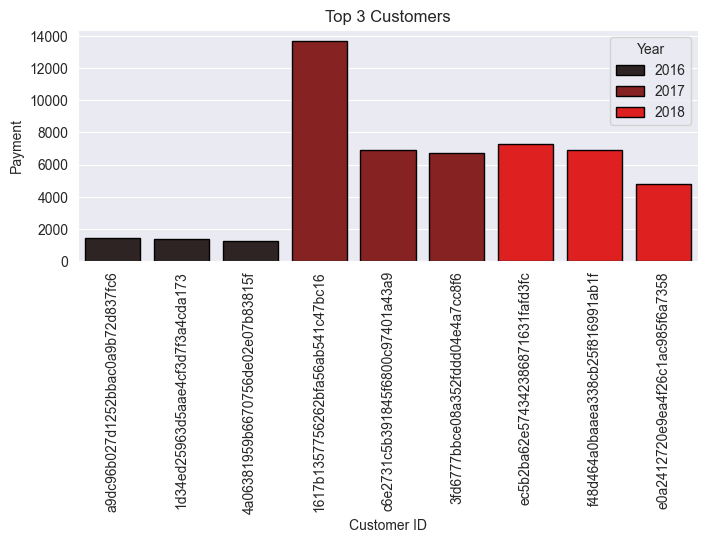

In [129]:
query = """SELECT years, customer_id, payment, d_rank
FROM
(SELECT YEAR(orders.order_purchase_timestamp) years,
orders.customer_id,
SUM(payments.payment_value) payment,
DENSE_RANK() over(PARTITION BY YEAR(orders.order_purchase_timestamp)
ORDER BY SUM(payments.payment_value) DESC) d_rank
FROM ecommerce.orders JOIN ecommerce.payments
ON payments.order_id = orders.order_id
GROUP BY year(orders.order_purchase_timestamp),
orders.customer_id) a
WHERE d_rank <= 3"""
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns = ['Year', 'Customer ID', 'Payment', 'Rank'])

plt.figure(figsize = (8,3))
sns.barplot(x = "Customer ID", y = "Payment", data = df, hue = "Year", palette = 'dark:red', edgecolor = "black")
plt.xlabel('Customer ID')
plt.ylabel('Payment')
plt.title('Top 3 Customers')
plt.xticks(rotation = 90)
plt.show()